In [4]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from tabpfn import TabPFNClassifier
import joblib
from utils.utils import get_train_test_val, eval, visual_test

# load the datasets
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val(path="../data_2025/clean/new_data.csv", val_size=.82)

accuracy: 0.7446592065106816


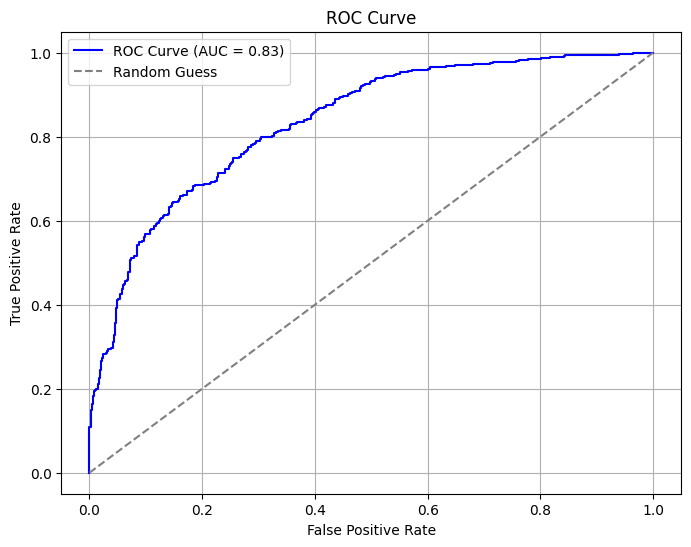

In [2]:
# start with linear model

lr = LogisticRegression(penalty='elasticnet', l1_ratio=.5, C=.1, solver='saga').fit(X_train, y_train)
y_probs = lr.predict_proba(X_test)[:, 1]  # gets the probability that team 0 wins
y_pred = lr.predict(X_test) # gets the binary winning team predictions (0 or 1)

eval(y_pred, y_test, y_probs)

accuracy: 0.7355035605289929


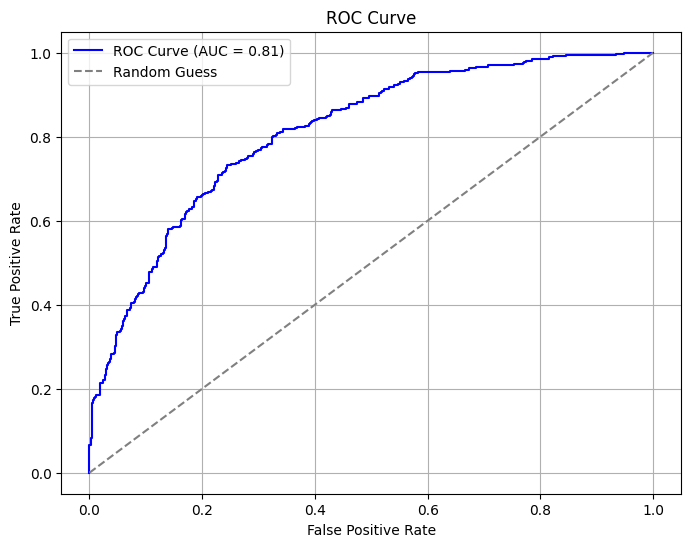

In [3]:
# Multi Layer Perceptron is the simplest neural network model
MLP = MLPClassifier(hidden_layer_sizes=(500, 300, 100, 25, 5), solver="adam", alpha=.01, early_stopping=True).fit(X_train, y_train)
y_probs = MLP.predict_proba(X_test)[:, 1]  # Get probability for the positive class
y_pred = MLP.predict(X_test)
eval(y_pred, y_test, y_probs)

accuracy: 0.7243133265513734


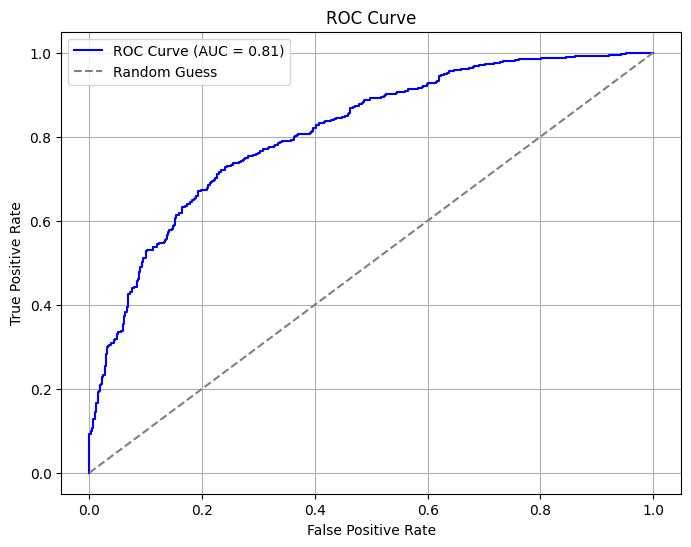

In [4]:
# smaller MLP
MLP_small = MLPClassifier(hidden_layer_sizes=(25, 20, 5), solver="adam", alpha=.1, early_stopping=True).fit(X_train, y_train)
y_pred = MLP_small.predict(X_test)
y_probs = MLP_small.predict_proba(X_test)[:, 1]
eval(y_pred, y_test, y_probs)

In [7]:
visual_test(MLP_small)

Game 1:
  TX Southern
  F Dickinson
  Prediction: F Dickinson: 0.698
  Actual winner: F Dickinson
------------------------------
Game 2:
  Arkansas
  Illinois
  Prediction: Illinois: 0.608
  Actual winner: Arkansas
------------------------------
Game 3:
  Iowa
  Auburn
  Prediction: Auburn: 0.590
  Actual winner: Auburn
------------------------------
Game 4:
  Oral Roberts
  Duke
  Prediction: Duke: 0.716
  Actual winner: Duke
------------------------------
Game 5:
  Virginia
  Furman
  Prediction: Virginia: 0.892
  Actual winner: Furman
------------------------------
Game 6:
  Houston
  N Kentucky
  Prediction: Houston: 0.982
  Actual winner: Houston
------------------------------
Game 7:
  Kansas
  Howard
  Prediction: Kansas: 0.955
  Actual winner: Kansas
------------------------------
Game 8:
  Maryland
  West Virginia
  Prediction: Maryland: 0.559
  Actual winner: Maryland
------------------------------
Game 9:
  Utah St
  Missouri
  Prediction: Utah St: 0.655
  Actual winner: Mis

c:\Users\rshul\.conda\envs\march_madness\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


accuracy: 0.7436419125127162


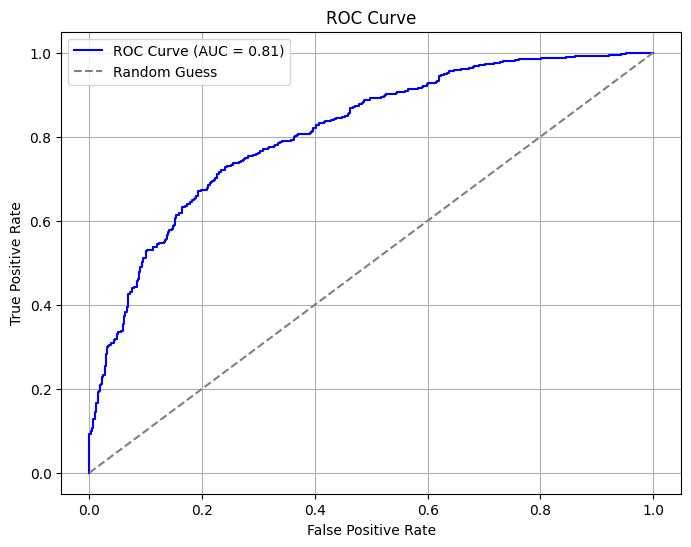

In [8]:
# XGBoost (https://arxiv.org/pdf/1603.02754) is often the best performing model on tabular datasets like ours
# Convert to DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 4,
    "learning_rate": 0.1,
    "n_estimators": 100
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_prob = model.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)
eval(y_pred, y_test, y_probs)

In [ ]:
# create the TabPFN model (https://arxiv.org/pdf/2207.01848)
# this loads a transformer model pretrained on general tabular data, and this finetunes it on our specific basketball dataset
model = TabPFNClassifier(model_path="model/tabpfn-v2-classifier.ckpt", device="cuda")

# finetunes the model on our specific basketball dataset
model.fit(X_train, y_train)

In [ ]:
# Save your trained model to a file in the "model" folder
joblib.dump(model, "model/saved_tabpfn.pkl")

['model/saved_tabpfn.pkl']

In [ ]:
# Load the saved model from the .pkl file
model = joblib.load("model/saved_tabpfn.pkl")

y_pred = model.predict(X_test) # gets the binary winning team predictions (0 or 1)
y_probs = model.predict_proba(X_test)[:, 1] # gets the probability that team 0 wins
eval(y_pred, y_test, y_probs)

In [ ]:
# visual_test is a way to look at its predictions from last year's tournament games to see if they make sense
visual_test(model)

Game 1:
  TX Southern
  F Dickinson
  Prediction: F Dickinson: 0.595
  Actual winner: F Dickinson
------------------------------
Game 2:
  Arkansas
  Illinois
  Prediction: Arkansas: 0.569
  Actual winner: Arkansas
------------------------------
Game 3:
  Iowa
  Auburn
  Prediction: Auburn: 0.508
  Actual winner: Auburn
------------------------------
Game 4:
  Oral Roberts
  Duke
  Prediction: Duke: 0.745
  Actual winner: Duke
------------------------------
Game 5:
  Virginia
  Furman
  Prediction: Virginia: 0.755
  Actual winner: Furman
------------------------------
Game 6:
  Houston
  N Kentucky
  Prediction: Houston: 0.976
  Actual winner: Houston
------------------------------
Game 7:
  Kansas
  Howard
  Prediction: Kansas: 0.969
  Actual winner: Kansas
------------------------------
Game 8:
  Maryland
  West Virginia
  Prediction: West Virginia: 0.529
  Actual winner: Maryland
------------------------------
Game 9:
  Utah St
  Missouri
  Prediction: Utah St: 0.612
  Actual winner